In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

# Bikes 🚲

[Slides](https://docs.google.com/presentation/d/1lQ3AcIMXd1pNFiAroYExzLOLq2HGSWrJj0p8OL8vT8Q/edit#slide=id.p22)

----

The data from today is about bike sharing demand from [a previously held Kaggle competition](https://www.kaggle.com/c/bike-sharing-demand/data).  Below is a bit of documentation from the competition.

---

> You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period.
>
> Data Fields
> ```
> datetime - hourly date + timestamp  
> season -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
> holiday - whether the day is considered a holiday
> workingday - whether the day is neither a weekend nor holiday
> weather - 1: Clear, 
>              Few clouds,
>              Partly cloudy, 
>              Partly cloudy
>           2: Mist + Cloudy, 
>              Mist + Broken clouds, 
>              Mist + Few clouds,
>              Mist
>           3: Light Snow,
>              Light Rain + Thunderstorm + Scattered clouds, 
>              Light Rain + Scattered clouds
>           4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, 
>              Snow + Fog 
> temp - temperature in Celsius
> atemp - "feels like" temperature in Celsius
> humidity - relative humidity
> windspeed - wind speed
> casual - number of non-registered user rentals initiated
> registered - number of registered user rentals initiated
> count - number of total rentals
> ```

From this list of column descriptions.

* What columns are categorical?  Which of these do you think we'll need to one-hot-encode?
* Do you see any columns that you expect to be multicollinear?

In the Kaggle competition the challenge was to predict the `count` column.  The `casual` and `registered` columns aren't allowed to be used since that information is really just the `count` column broken out into its components (i.e. `count = casual + registered`).

In [2]:
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

In [3]:
def print_vif(x):
    """Utility for checking multicollinearity assumption
    
    :param x: input features to check using VIF. This is assumed to be a pandas.DataFrame
    :return: nothing is returned the VIFs are printed as a pandas series
    """
    # Silence numpy FutureWarning about .ptp
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        x = sm.add_constant(x)

    vifs = []
    for i in range(x.shape[1]):
        vif = variance_inflation_factor(x.values, i)
        vifs.append(vif)

    print("VIF results\n-------------------------------")
    print(pd.Series(vifs, index=x.columns))
    print("-------------------------------\n")

<IPython.core.display.Javascript object>

### Let's do some general EDA

In [4]:
# data from https://www.kaggle.com/c/bike-sharing-demand/data
data_url = "https://docs.google.com/spreadsheets/d/1GJrx_Y3cvD1sWLg_zF_mMZZ0iZ_If2E02VIkyCi3PTc/export?format=csv"
bike_sharing = pd.read_csv(data_url)

<IPython.core.display.Javascript object>

In [5]:
bike_sharing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


<IPython.core.display.Javascript object>

In [6]:
bike_sharing.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


<IPython.core.display.Javascript object>

In [7]:
bike_sharing = bike_sharing.drop(columns=["casual", "registered"])
bike_sharing.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 0:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 1:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 2:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 3:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 4:00:00,1,0,0,1,9.84,14.395,75,0.0,1


<IPython.core.display.Javascript object>

In [11]:
bike_sharing["datetime"] = pd.to_datetime(bike_sharing["datetime"])

bike_sharing["hour"] = bike_sharing["datetime"].dt.hour
bike_sharing["day_of_week"] = bike_sharing["datetime"].dt.day_name()
bike_sharing.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour,day_of_week
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16,0,Saturday
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40,1,Saturday
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32,2,Saturday
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13,3,Saturday
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1,4,Saturday


<IPython.core.display.Javascript object>

The column `datetime` itself isn't very useful.  Why is that and how might we get some useful info out of the column?

Drop the datetime column

In [12]:
bike_sharing = bike_sharing.drop(columns="datetime")

<IPython.core.display.Javascript object>

Investigate the column datatypes to make sure there's nothing unexpected

Do we have missing values we need to handle?

In [13]:
bike_sharing.isna().sum()

season         0
holiday        0
workingday     0
weather        0
temp           0
atemp          0
humidity       0
windspeed      0
count          0
hour           0
day_of_week    0
dtype: int64

<IPython.core.display.Javascript object>

Calculate summary statistics.  When doing this, pay extra attention to our response variable, `count`.

In [14]:
bike_sharing.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,hour
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,191.574132,11.541613
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,181.144454,6.915838
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,1.000000,0.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,42.000000,6.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,145.000000,12.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,284.000000,18.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,977.000000,23.000000


<IPython.core.display.Javascript object>

(array([4284., 2337., 1686., 1067.,  633.,  426.,  233.,  116.,   85.,
          19.]),
 array([  1. ,  98.6, 196.2, 293.8, 391.4, 489. , 586.6, 684.2, 781.8,
        879.4, 977. ]),
 <a list of 10 Patch objects>)

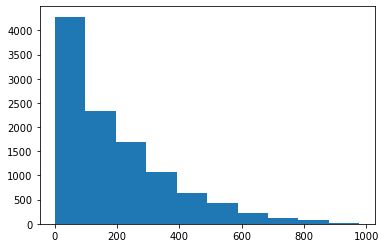

<IPython.core.display.Javascript object>

In [17]:
plt.hist(bike_sharing["count"])

Plot a `scatter_matrix`/`pairplot` of our dataframe

In [19]:
bike_sharing.columns

Index(['season', 'holiday', 'workingday', 'weather', 'temp', 'atemp',
       'humidity', 'windspeed', 'count', 'hour', 'day_of_week'],
      dtype='object')

<IPython.core.display.Javascript object>

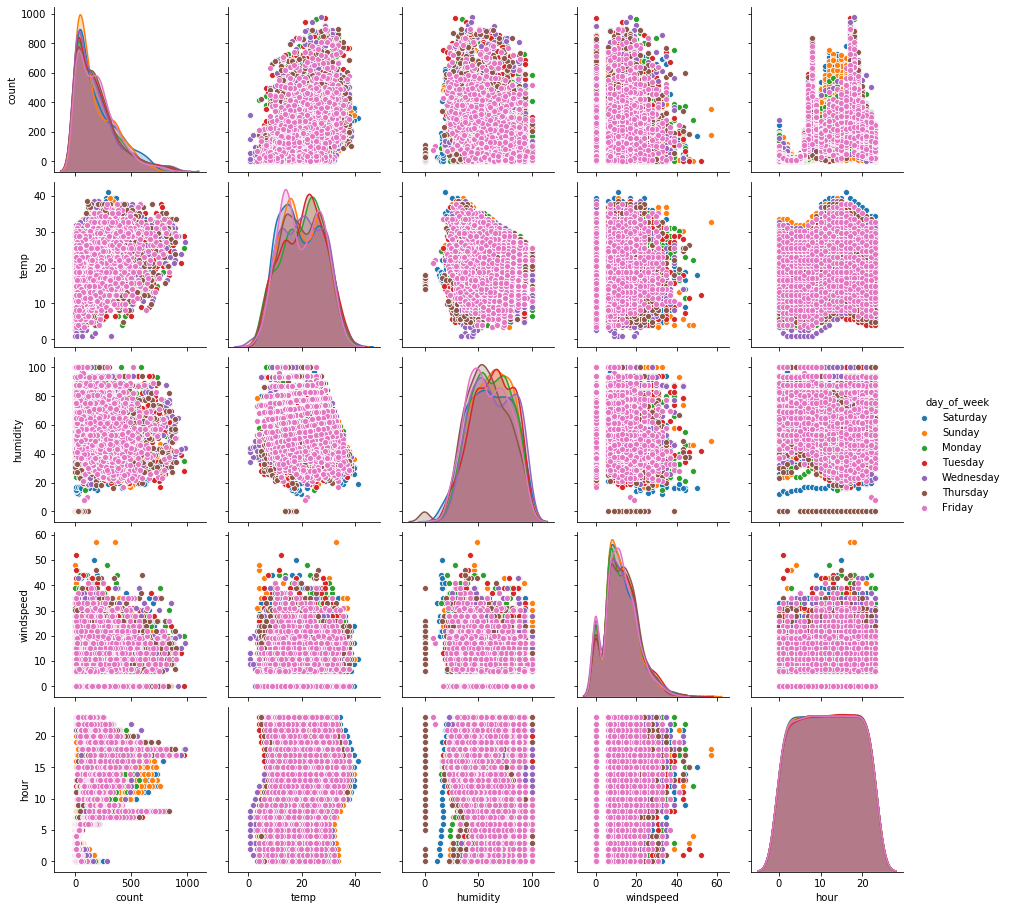

<IPython.core.display.Javascript object>

In [25]:
sns.pairplot(
    bike_sharing[["count", "temp", "humidity", "windspeed", "hour", "day_of_week",]],
    hue="day_of_week",
)

Some things to point out.

* Its not the strongest thing, but, temperature seems to have an effect on rentals (the higher the temp the more rentals).  This effect seems more prominent in the casual rentals.
* Both humidity and windspeed seem to have negative effects.  When they're low, there doesn't seem to be a big correlation, but when these factors are high we see a drop off in rentals.
* We won't be using this information, but note the plots between casual & count.  We see a pretty distinct v-shape, this is indicative of an interaction happening somewhere.  That is, there seems to be 2 distinct groups of data, we could try and explore and find a reason for this split.
* Our response variable `count` is a very positively skewed distribution.  This indicates that we might want to perform a transformation to it.  For now we'll leave it, and come back to this.

Plot the distribution of the response

The boxplot of our response variable also shows some outliers we might want to deal with.  This is something we might come back to.

## Prep data for modeling

One-hot encode features where appropriate

In [ ]:
cat_cols = ["day_of_week"]
drop_cats = ["Saturday"]

num_cols = [
    "season",
    "weather",
    "temp",
    "atemp",
    "humidity",
    "windspeed",
    "hour",
]

bin_cols = ['holiday', 'workingday']

ct = ColumnTransformer(
    #   Format
    #   [("name of step", WhatToDo(), list_of_columns_to_do_it_to)]
    [("one_hot_encode", OneHotEncoder(drop=drop_cats), cat_cols)],
    [()]
    # What should we do to the rest of the data?
    remainder=StandardScaler(),


<IPython.core.display.Javascript object>

In [ ]:
ct.fit(X_train)

X_train_trans = ct.transform(X_train)
X_test_trans = ct.transform(X_test)

In [ ]:
cat_names = ct.transformers_[0][1].get_feature_names(cat_cols)
cat_names = list(cat_names)
new_col_names = cat_names + num_cols

X_train = pd.DataFrame(X_train_trans, index=X_train.index, columns=new_col_names)
X_test = pd.DataFrame(X_test_trans, index=X_test.index, columns=new_col_names)

X_train.head(2)

Separate data into its `X` and `y` components, and perform a `train_test_split`

In [27]:
X = bike_sharing.drop(columns="count")
y = bike_sharing["count"]

<IPython.core.display.Javascript object>

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

Assess multicollinearity with variance inflation factor.

Address any issues with collinearity

## Build a ridge regression model

Build a plain ole `LinearRegression` model for comparison

Build a fancy ole Ridge regression model

No real change in our $R^2$ here.. whats the deal man? I thought this was used to make things better.  Remember what the loss function is doing.  We're including a penalty for large coefficients, so let's see how they changed.

Let's actually see numbers other than $R^2$.  How are our predictions?

We want to fall evenly around that line.  Right now, we're underpredicting high values.  In our EDA we made a comment about our response's skewed distribution.  We might want to reconsider a transformation.  A log transformation is a good one to start with for right skewed data.

Refit the model on a logged version of `y`.

Re-evaluate the predictions

## Build a LASSO regression model 🤠

How are our coefficients looking now?

Well... the coefficient shrinking definitely did its thing here... We probably want a better way of selecting an alpha than guess and check.  This is where cross validation comes into play paired with something called a gridsearch.  All the grid search does is find the best combination of hyperparameters that we tell it to test.  Here our only hyperparameter will be alpha.

Let's fit lasso using a gridsearch for the best alpha.  After we fit the model lets view the best alpha and the new coefficients.

In [ ]:
grid = {'alpha': [0.001, 0.01, 0.1]}
lasso_cv = GridSearchCV(Lasso(), grid, verbose=1)
lasso_cv

# The best fit is in the best_estimator_ attribute
print(f"selected alpha: {lasso_cv.best_estimator_.alpha}")
lasso_cv.best_estimator_.coef_

Evaluate the predictions

We're now on par with the ridge regression results.  Not the most fair comparison though, with ridge regression we didn't grid search, we just made up a value for alpha.  On your own you can implement grid search for the ridge regression and see how/if the results improve.

## Build an elasticnet regression model

In [ ]:
grid = {_: [], __: [], }
elasticnet_cv = GridSearchCV(ElasticNet(), grid, verbose=1)
elasticnet_cv.fit(X_train, np.log(y_train))

print(f"selected alpha: {elasticnet_cv.best_estimator_.alpha}")
print(f"selected l1_ratio: {elasticnet_cv.best_estimator_.l1_ratio}")
elasticnet_cv.best_estimator_.coef_

The `l1_ratio` selected was 1.0... what does this mean?  (the answer to this question is also the reason why there's no analysis on the model results)